# Determining the Impact of Economic Measures on the Trajectory of the Agricultural Industry (Milestone 2)
Harper Lyon

https://harplyon.github.io/CMPS6790FinalTutorial/

## Guiding Questions:

The mythology of Small Farmers vs Big Ag is familiar to many Americans, but like any element of the American mythology we should be somewhat suspicious - especially when politicians and economicists claim that their new policies will help (or even "save") small farms. Today we'll be trying to get a data based answer to the question of what factors actually have an impact on the fate of the American agricultural industry, which is obviously a moderately well studied question. While we might not be able to match the quality of analysis of the USDA we can at least use their data and learn a bit about data science as we go. There are two main questions that we'll be asking:

* What measures (like Government payments to farmers, taxes, debt, etc) tell us whether an agricultural industry grows or slows in general?
* What measures tell us whether the relative share of small farmers vs big ag operations will go up or down?

To attempt to answer these questions we'll be using data both from the USDA directly and from the Agricultural Resource Management Survey, which gives us a chance to do both some classic webscraping and to use a real web API. From the USDA we'll take high quality data from the USDA census on the value of different agricultural industries in each state, and the ARMS survey will tell us more about basically any economic indicator we could ask for, but it is more limited in scope as it only covers 15 states and is inherently less reliable due to its status as a voluntary survey.

The ultimate goal is to combine this data and use it to create a linear regression model for predicting the change in agricultral productivity and farm size* over the years. From there (assuming we get an accurate model) we can extract the coefficients to analyze the relationship of each indicator in our data to both measures. The ideal outcome here is the ability to say that "In our linear model the Tax rate has a coefficient of -10, so we can see that high taxes predict low or no growth in an agricultural sector", but we've got a lot of work until we get there.

## Setup and Imports

In [1]:
!pip3 install lxml
!pip3 install html5lib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import functools
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup

## Scraping & Cleaning

### USDA QuickStats Data:

While the USDA data we'll be using is actually downloadable in many convenient formats we'll access it via webscraping for tutorial purposes. We'll be grabbing the data from [this table](https://quickstats.nass.usda.gov/results/EA7182BD-87D0-3E47-A9C0-A9D9260F3794), which is just the results of searching for sales of by crop by state in all census years. However, while we won't be using the download data feature of the USDA website we *will* be accessing a slightly [easier to parse version of their site](https://quickstats.nass.usda.gov/data/printable/0A90D9FE-6F14-3E82-83C7-BC9FB48E126A), which is just the same table but formated for printing, so the html is a bit cleaner. Let's start by requesting the page and making some beautiful soup.

In [3]:
# we have to trick the usda, which I hope isn't a felony
sales_request = requests.get("https://quickstats.nass.usda.gov/data/printable/0A90D9FE-6F14-3E82-83C7-BC9FB48E126A",
                headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:101.0) Gecko/20100101 Firefox/101.0'})
assert sales_request.status_code == 200

In [4]:
sales_soup = BeautifulSoup(sales_request.text, "html.parser")

And thank Uncle Sam this reads into pandas nice and cleanly.

In [5]:
sales_df = pd.read_html(str(sales_soup.find("table")))[0]
sales_df.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (111),1180774000,2.8
1,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (1111),315393000,5.6
2,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (11111),62429000,8.6
3,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (11112),10000,(H)
4,CENSUS,2017,YEAR,NaN,STATE,ALABAMA,1,NaN,NaN,NaN,...,NaN,NaN,0,NaN,COMMODITY TOTALS,"COMMODITY TOTALS - SALES, MEASURED IN $",NAICS CLASSIFICATION,NAICS CLASSIFICATION: (11113),7000,55.7


There are a few steps to cleaning here, let's start by dropping all columsn we don't need, all of which are either single valued (e.d. Period), empty (e.g. Week Ending), or essential duplicates of other columns (e.g. State ANSI). Note that this step doesn't actually remove any information from the data set - we're strictly getting rid of duplicate or empty data. Also, on a programming level, notice that we can just do this by simply grabbing the handful of columns we *do* want. This leaves us with the following data:

* Year: The year of the census this data is from.
* State: The state this data is from.
* Domain Category: The (badly titled - we'll fix that soon) NAICS classification of the crop this data represents.
* Value: The value of the crop from the state in a particular year.

In [6]:
sales_df = sales_df.loc[:, ['Year', 'State', 'Domain Category', 'Value']]
sales_df

,Year,State,Domain Category,Value
0,2017,ALABAMA,NAICS CLASSIFICATION: (111),1180774000
1,2017,ALABAMA,NAICS CLASSIFICATION: (1111),315393000
2,2017,ALABAMA,NAICS CLASSIFICATION: (11111),62429000
3,2017,ALABAMA,NAICS CLASSIFICATION: (11112),10000
4,2017,ALABAMA,NAICS CLASSIFICATION: (11113),7000
...,...,...,...,...
9895,2002,WYOMING,NAICS CLASSIFICATION: (1125),3210000
9896,2002,WYOMING,NAICS CLASSIFICATION: (1129),21966000
9897,2002,WYOMING,NAICS CLASSIFICATION: (11291),2255000
9898,2002,WYOMING,NAICS CLASSIFICATION: (11292),10392000


This is looking a lot more manageable, but now we have some data type/inconsistent value problems.First is that ugly Domain Category column - not only is it badly named, it's also in a pretty ugly format. Let's create a new column and extraxt the actual classification value from each row, then drop the original column.

In [7]:
sales_df.loc[:, 'NAICS'] = [re.findall(r"\d+", s)[0] for s in sales_df['Domain Category']]
sales_df.drop(['Domain Category'], axis=1, inplace=True)
sales_df

,Year,State,Value,NAICS
0,2017,ALABAMA,1180774000,111
1,2017,ALABAMA,315393000,1111
2,2017,ALABAMA,62429000,11111
3,2017,ALABAMA,10000,11112
4,2017,ALABAMA,7000,11113
...,...,...,...,...
9895,2002,WYOMING,3210000,1125
9896,2002,WYOMING,21966000,1129
9897,2002,WYOMING,2255000,11291
9898,2002,WYOMING,10392000,11292


So, we now have the data we actually care about for this column, but it's still not perfect - what even is an NAICS class? Well NAICS is simply a set of codes that the government uses to denote specific industries. Anything that starts with 11 is Agriculture, 111 is crops (vegetable, fruits, ect), 112 livestock, etc. This goes on to very high level of specificity, for instance 111110 is Soybeans, and 111120 is non-soybean oilbeans. The real question of this data cleaning stage is how to handle NAICS - we could compress everything to fairly high level categories (say 4 digits, this would be on the level of Grain, Vegetable, Hog, Cattle, etc) and drop all other data - this has the advantage of reducing the size of our dataset and being easy to translate NAICS codes. We could also translate each individual NAICS code to get a more granular break down. Eventually we'll want to do the later, but handling each code is a lot of work - for the purposes of exploration let's just translate the four digit codes and create a condensed dataframe.

In [8]:
sales_df = sales_df.loc[[len(code) == 4 for code in sales_df['NAICS']]].copy()
sales_df.reset_index(inplace=True)

Now we can create a new column for the meanings of the codes, which for now we'll convert manually with a dictionary.

In [9]:
naics_dict = {
    '1111' : 'Oilseed and Grain',
    '1112' : 'Vegetable and Melon',
    '1113' : 'Fruit and Tree Nut',
    '1114' : 'Greenhouse, Nursery, and Floriculture',
    '1119' : 'Other Crops',
    '1121' : 'Cattle',
    '1122' : 'Hog',
    '1123' : 'Poultry',
    '1124' : 'Sheep and Goat',
    '1125' : 'Aquaculture',
    '1129' : 'Other Animals'
}

sales_df.loc[:, 'Category'] = [naics_dict[code] for code in sales_df['NAICS']]
print(sales_df.dtypes)
sales_df

index        int64
Year         int64
State       object
Value       object
NAICS       object
Category    object
dtype: object


,index,Year,State,Value,NAICS,Category
0,1,2017,ALABAMA,315393000,1111,Oilseed and Grain
1,8,2017,ALABAMA,53633000,1112,Vegetable and Melon
2,11,2017,ALABAMA,16156000,1113,Fruit and Tree Nut
3,22,2017,ALABAMA,295784000,1114,"Greenhouse, Nursery, and Floriculture"
4,27,2017,ALABAMA,499808000,1119,Other Crops
...,...,...,...,...,...,...
2295,9888,2002,WYOMING,22536000,1122,Hog
2296,9889,2002,WYOMING,546000,1123,Poultry
2297,9892,2002,WYOMING,25076000,1124,Sheep and Goat
2298,9895,2002,WYOMING,3210000,1125,Aquaculture


With this we're almost done, just have to deal with the typing on the Value column - currently that's strings because of some "(D)" values. In the dataset that means that the USDA isn't publishing the data because it would compromise the details of an operation - usually because there's only one, say, citrus orchard in Alaska. We got rid of most of those when we compressed the dataset into just the major categories, but there are still a few. We'll replace those with NaN - this might not be the best approach if we wanted to do real predictive work, but for exploration purposes it's fine.

In [10]:
sales_df['Value'] = [float(val) if val != '(D)' else np.nan for val in sales_df['Value']]
sales_df.dtypes

index         int64
Year          int64
State        object
Value       float64
NAICS        object
Category     object
dtype: object

### Agricultural Resource Management Survey Data

If we want to do anything more interesting than look at sales we need to know more about the ways that farms are operating, which leads us to ARMS, a massive survey run each year to gather data on Farmer income, expenses, demographics, and many other categories of information. We'll specifically be accessing information on government support of farms (in the form of direct payments, favorable loans, etc.) and the average taxes paid by farms - again all broken down by state and industry. This data is accessed through a RESTFUL API, so we'll be using the python requests library in a slightly more advanced way. The instructions and information for the ARMS API is all available at [this website](https://www.ers.usda.gov/developer/data-apis/arms-data-api/). Let's start by making requests for the following information sets:

* Total payments from government programs to farms per state per industry.
* Average gross taxes paid by farms per state per industry.
* The average Cost to Dept ratio for each farm.
* The average Liabilities (debt) for each farm.
* The average Labor Cost per farm.
* The Average Gross Income per farm.

Note that last value - the average gross income per farm. This value is especially important to our analysis because we're going to use it as a proxy for farm size. Obtaining good data on the relative farm size in each industry/state has proven quite difficult, so we're going to focus on average income with the rationale that high average income means that the average farm is big, and low means the average farm is small. This is obviously an imperfect metric, but it's the best I've found so far.

In [11]:
# store my personal api key for easy use
api_key = "mxBy9mHz74LQcxQk5MsSkVapoTAJ6R3yy0uo6uER"

# define the years we're interested in (the same as present in the USDA census) and ask the API for the available states
years = ['2002', '2007', '2012', '2017']
states = [d['name'] for d in requests.get("https://api.ers.usda.gov/data/arms/state?api_key=" + api_key).json()['data'][1:]]

# here we make the requests - each is a .get to a specific URL which includes my key, the years and states we're interested in, as well as the variable code and the category breakdowns
payments = requests.get("https://api.ers.usda.gov/data/arms/surveydata?api_key=" + api_key + "&year=" + ','.join(years) + "&state=" + ','.join(states) + "&variable=igovtt&category=spec")
taxes = requests.get("https://api.ers.usda.gov/data/arms/surveydata?api_key=" + api_key + "&year=" + ','.join(years) + "&state=" + ','.join(states) + "&variable=eftaxes&category=spec")
cost_ratio = requests.get("https://api.ers.usda.gov/data/arms/surveydata?api_key=" + api_key + "&year=" + ','.join(years) + "&state=" + ','.join(states) + "&variable=freconum&category=spec")
liabilities = requests.get("https://api.ers.usda.gov/data/arms/surveydata?api_key=" + api_key + "&year=" + ','.join(years) + "&state=" + ','.join(states) + "&variable=dtot&category=spec")
labor_cost = requests.get("https://api.ers.usda.gov/data/arms/surveydata?api_key=" + api_key + "&year=" + ','.join(years) + "&state=" + ','.join(states) + "&variable=evlabor&category=spec")
avg_gross = requests.get("https://api.ers.usda.gov/data/arms/surveydata?api_key=" + api_key + "&year=" + ','.join(years) + "&state=" + ','.join(states) + "&variable=igcfioth&category=spec")

Each of these requests gives us a json object, which contains a few bits of request information (status, time, record count, etc), but also all of the data. We can feed those into pandas to generate a dataframe:

In [12]:
payments_df = pd.DataFrame(payments.json()['data'])
taxes_df = pd.DataFrame(taxes.json()['data'])
cost_ratio_df = pd.DataFrame(cost_ratio.json()['data'])
liabilities_df = pd.DataFrame(liabilities.json()['data'])
labor_cost_df = pd.DataFrame(labor_cost.json()['data'])
avg_gross_df = pd.DataFrame(avg_gross.json()['data'])

payments_df

,year,state,report,farmtype,category,category_value,category2,category2_value,variable_id,variable_name,...,variable_group_id,variable_unit,variable_description,variable_is_invalid,estimate,median,statistic,rse,unreliable_estimate,decimal_display
0,2007,Georgia,Government Payments,All Farms,Production Specialty,General Cash Grains,All Farms,TOTAL,igovtt,All government payments,...,5,"1,000 Dollars",Total government payments include direct payme...,False,11368.0,None,TOTAL,57.4,0,0
1,2017,Georgia,Government Payments,All Farms,Production Specialty,General Cash Grains,All Farms,TOTAL,igovtt,All government payments,...,5,"1,000 Dollars",Total government payments include direct payme...,False,NaN,None,TOTAL,NaN,0,0
2,2012,Georgia,Government Payments,All Farms,Production Specialty,Wheat,All Farms,TOTAL,igovtt,All government payments,...,5,"1,000 Dollars",Total government payments include direct payme...,False,NaN,None,TOTAL,NaN,0,0
3,2017,Georgia,Government Payments,All Farms,Production Specialty,Wheat,All Farms,TOTAL,igovtt,All government payments,...,5,"1,000 Dollars",Total government payments include direct payme...,False,NaN,None,TOTAL,NaN,0,0
4,2017,Georgia,Government Payments,All Farms,Production Specialty,Corn,All Farms,TOTAL,igovtt,All government payments,...,5,"1,000 Dollars",Total government payments include direct payme...,False,NaN,None,TOTAL,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,2017,Wisconsin,Government Payments,All Farms,Production Specialty,Poultry,All Farms,TOTAL,igovtt,All government payments,...,5,"1,000 Dollars",Total government payments include direct payme...,False,645.0,None,TOTAL,79.0,0,0
492,2007,Wisconsin,Government Payments,All Farms,Production Specialty,Dairy,All Farms,TOTAL,igovtt,All government payments,...,5,"1,000 Dollars",Total government payments include direct payme...,False,72752.0,None,TOTAL,7.6,0,0
493,2012,Wisconsin,Government Payments,All Farms,Production Specialty,Dairy,All Farms,TOTAL,igovtt,All government payments,...,5,"1,000 Dollars",Total government payments include direct payme...,False,132690.0,None,TOTAL,5.8,0,0
494,2007,Wisconsin,Government Payments,All Farms,Production Specialty,All other livestock,All Farms,TOTAL,igovtt,All government payments,...,5,"1,000 Dollars",Total government payments include direct payme...,False,9902.0,None,TOTAL,52.0,0,0


As you can probably tell from the peek into the payments data above, this data has way to many columns, including many which just explain the values found in other columns. Let's go ahead and grab only the columns we care about for each frame - the year, state, category_value, and "estimate", which is ARMS name for the value (they're just hedging their language based on the fact that this is a survey - which we should keep in mind as well).

In [13]:
# While dropping out the columns we don't care about we're going to also rename the columns to match those in the USDA data
payments_df = payments_df.loc[:, ['year', 'state', 'category_value', 'estimate']].rename(columns={'year':'Year', 'state':'State', 'category_value':'Category', 'estimate':'Payments'})
taxes_df = taxes_df.loc[:, ['year', 'state', 'category_value', 'estimate']].rename(columns={'year':'Year', 'state':'State', 'category_value':'Category', 'estimate':'Taxes'})
cost_ratio_df = cost_ratio_df.loc[:, ['year', 'state', 'category_value', 'estimate']].rename(columns={'year':'Year', 'state':'State', 'category_value':'Category', 'estimate':'Cost Income Ratio'})
liabilities_df = liabilities_df.loc[:, ['year', 'state', 'category_value', 'estimate']].rename(columns={'year':'Year', 'state':'State', 'category_value':'Category', 'estimate':'Liability'})
labor_cost_df = labor_cost_df.loc[:, ['year', 'state', 'category_value', 'estimate']].rename(columns={'year':'Year', 'state':'State', 'category_value':'Category', 'estimate':'Labor'})
avg_gross_df = avg_gross_df.loc[:, ['year', 'state', 'category_value', 'estimate']].rename(columns={'year':'Year', 'state':'State', 'category_value':'Category', 'estimate':'Avg Gross'})

payments_df

,Year,State,Category,Payments
0,2007,Georgia,General Cash Grains,11368.0
1,2017,Georgia,General Cash Grains,NaN
2,2012,Georgia,Wheat,NaN
3,2017,Georgia,Wheat,NaN
4,2017,Georgia,Corn,NaN
...,...,...,...,...
491,2017,Wisconsin,Poultry,645.0
492,2007,Wisconsin,Dairy,72752.0
493,2012,Wisconsin,Dairy,132690.0
494,2007,Wisconsin,All other livestock,9902.0


We're going to do some additional processing here, but first we can join these requests so that we can stop keeping track of multiple dataframes.

In [14]:
# We'll package all the requests into a list so we can iterattively merge
all_requests = [payments_df, taxes_df, cost_ratio_df, liabilities_df, labor_cost_df, avg_gross_df]

#Our data isn't really big enough to make using reduce a large advantage here, but if we had either more rows or more frames we would see a large difference in speed
survey_df = functools.reduce(lambda a, b : pd.merge(a, b, on=['Year', 'State', 'Category'], how='outer'), all_requests)

Alright we're down to one frame now. First thing we need to do is get the Payments column into full dollar values (as it is in sales), which is just a matter of multiplying all values by 1000. All the other columns already operate in dollars (or dollars / farm), so it isn't clear why only government payments are measured in thousands. Just goes to show you should always be careful about units. Of course, it won't matter much once we standardize all these values, but until then it's good to have consistent units.

In [15]:
survey_df['Payments'] = survey_df['Payments'].map(lambda x : x * 1000)

In [16]:
survey_df

,Year,State,Category,Payments,Taxes,Cost Income Ratio,Liability,Labor,Avg Gross
0,2007,Georgia,General Cash Grains,11368000.0,3259.0,131.3,81169.0,17120.0,81742.0
1,2007,Georgia,General Cash Grains,11368000.0,3259.0,131.3,81169.0,17120.0,81742.0
2,2017,Georgia,General Cash Grains,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,Georgia,General Cash Grains,NaN,NaN,NaN,NaN,NaN,NaN
4,2012,Georgia,Wheat,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
987,2012,Wisconsin,Dairy,132690000.0,6402.0,99.2,421853.0,48829.0,667892.0
988,2007,Wisconsin,All other livestock,9902000.0,3329.0,322.4,63133.0,2754.0,146618.0
989,2007,Wisconsin,All other livestock,9902000.0,3329.0,322.4,63133.0,2754.0,146618.0
990,2017,Wisconsin,All other livestock,3099000.0,3283.0,250.8,91014.0,2588.0,NaN


## Joining

We now need to combine these two datasets, which means deciding which columns (if any) we'll be matching and making sure they're ready to match up. In this case we're going to match on three values - year, state, and category. We're going to focus on changing the survey data to match the sales data - though we could easily choose to do the reverse. Some of these edits are easy, year already matches and state is just a matter of capitalization, but matching categories is harder. Let's perform that easy change and take a closer look at the two category value sets.

In [17]:
# changing state format to match sales data
survey_df['State'] = survey_df['State'].map(lambda x : x.upper())

print("Categories in USDA sales data: ", sales_df['Category'].unique())
print()
print("Categories in ARMS data: ", survey_df['Category'].unique())

Categories in USDA sales data:  ['Oilseed and Grain' 'Vegetable and Melon' 'Fruit and Tree Nut'
 'Greenhouse, Nursery, and Floriculture' 'Other Crops' 'Cattle' 'Hog'
 'Poultry' 'Sheep and Goat' 'Aquaculture' 'Other Animals']

Categories in ARMS data:  ['General Cash Grains' 'Wheat' 'Corn' 'Soybean' 'Other Field Crops'
 'Cattle' 'Hogs' 'Poultry' 'All other livestock' 'Dairy'
 'Specialty Crops (F,V,N)' 'Tobacco, Cotton, Peanuts']


Here we need to make some decisions on how to match up these categories. Below is how I'll be mapping each category that doesn't have a clear 1-1 mapping (i.e. Hogs to Hog):

* General Cash Grains, Wheat, Corn, Soybean -> Oilseed and Grain
* Other Field Crops, Tobacco, Cotton, Peanuts -> Other Crops
* Dairy -> Cattle

This leaves us with the categories 'All other livestock' and 'Specialty Crops (F, V, N)' (stands for Fruit, Vegetable, Nut), which have the problem of spanning multiple categories in the USDA dataset. Since we have no way of dividing these, we have a two real choices - we can drop the entries entirely, leading to us having no data to augment those categories in the sales data (note that this is already going to happen to Aquaculture which is not included in the survey) or we can combine the categories in the USDA data (e.g. merge Vegetable and Melon, Fruit and Tree Nut, and Greenhouse, Nursery, and Floriculture'). Let's make an informed decision - how much data would we be losing or combining?

In [18]:
specialty_count = sales_df[sales_df['Category'].isin(['Vegetable and Melon', 'Fruit and Tree Nut', 'Greenhouse, Nursery, and Floriculture'])].shape[0]
print(f"There are {specialty_count} observations which would be in the new Specialty Crops category, or {(specialty_count / sales_df.shape[0]) * 100 :.2f}%" )
animal_count = sales_df[sales_df['Category'].isin(['Other Animals', 'Sheep and Goat'])].shape[0]
print(f"There are {animal_count} observations which would be in the new Other Animals category, or {(animal_count / sales_df.shape[0]) * 100 :.2f}%")

There are 600 observations which would be in the new Specialty Crops category, or 26.09%
There are 400 observations which would be in the new Other Animals category, or 17.39%


That's a fair bit of data to merge, given that we have a total of 2300 observations - but hold up, we know we're going to be dropping several states from the analysis already, do our numbers improve there?

In [19]:
#we can reach back and use the list of states we requested from the ERS in the scraping step
states_filtered = sales_df[sales_df['State'].isin([s.upper() for s in states])]
print(f"By filtering states not present in the ARMS survey data we removed {sales_df.shape[0] - states_filtered.shape[0]} entries, leading to new merging considerations below:")

specialty_count = states_filtered[states_filtered['Category'].isin(['Vegetable and Melon', 'Fruit and Tree Nut', 'Greenhouse, Nursery, and Floriculture'])].shape[0]
print(f"There are {specialty_count} observations which would be in the new Specialty Crops category, or {(specialty_count / states_filtered.shape[0]) * 100 :.2f}%" )
animal_count = states_filtered[states_filtered['Category'].isin(['Other Animals', 'Sheep and Goat'])].shape[0]
print(f"There are {animal_count} observations which would be in the new Other Animals category, or {(animal_count / states_filtered.shape[0]) * 100 :.2f}%")

By filtering states not present in the ARMS survey data we removed 1610 entries, leading to new merging considerations below:
There are 180 observations which would be in the new Specialty Crops category, or 26.09%
There are 120 observations which would be in the new Other Animals category, or 17.39%


Turns out when you're dealing with an fundamentally combinatorial dataset (there is one and only one entry for each possibility of year, state, and category in the sales data), you're not going to get a better deal with a smaller dataset. I think this is a reasonable merge to perform, as the alternative is to drop more than a third of our total data which I'm just not willing to do at this stage. Hopefully the ARMS folks were onto something by grouping together these categories. So we now have to perform transformations on both frames to prepare for the merge - we have to translate then merge (via groupby) the various categories in both sales_df and survey_df.

In [20]:
#Translation scheme for sales data categories
sales_translation = {'Vegetable and Melon' : 'Specialty Crop', 'Fruit and Tree Nut' : 'Specialty Crop', 'Greenhouse, Nursery, and Floriculture' : 'Specialty Crop',
                     'Sheep and Goat' : 'Other Animals'}

#Applying translation and merging the new categories into each other
sales_df['Category'] = sales_df['Category'].map(lambda x : sales_translation.get(x, x))
sales_df = sales_df.groupby(['Year', 'State', 'Category'])['Value'].sum().reset_index()

That's the sales data done - pretty straightforward. The survey data is a bit trickier because we're translating more categories and also have to be merge more variables for the final data. Pay particular attention to how we aggregate different values differently - total values like Payments get summed, while average or per farm columns (pretty much everything else) gets averaged (since it doesn't really make sense to just add averages together).

In [21]:
#Because of the high degree of redundancy in the translations a function is prefered to a dictionary here
def translate_survey_category(cat):
    if cat in ['General Cash Grains', 'Wheat', 'Corn', 'Soybean']:
        return 'Oilseed and Grain'
    if cat in ['Other Field Crops', 'Tobacco, Cotton, Peanuts']:
        return 'Other Crops'
    if cat in ['Cattle', 'Dairy']:
        return 'Cattle'
    if cat == 'Hogs':
        return 'Hog'
    if cat == 'Specialty Crops (F,V,N)':
        return 'Specialty Crop'
    if cat == 'All other livestock':
        return 'Other Animals'
    return cat

#translating categories
survey_df['Category'] = survey_df['Category'].map(translate_survey_category)
#merging newly matched rows - we need to be careful to apply the correct kind of merge as we don't to sum averages
survey_df = survey_df.groupby(['Year', 'State', 'Category']).agg({'Payments' : 'sum', 'Taxes' : 'mean', 'Cost Income Ratio' : 'mean', 'Liability' : 'mean', 'Labor' : 'mean', 'Avg Gross' : np.mean}).reset_index()
survey_df

,Year,State,Category,Payments,Taxes,Cost Income Ratio,Liability,Labor,Avg Gross
0,2007,ARKANSAS,Cattle,23552000.0,1123.000000,241.200000,21327.000000,1503.000000,2.909900e+04
1,2007,ARKANSAS,Hog,0.0,1442.000000,89.200000,43809.000000,13510.000000,NaN
2,2007,ARKANSAS,Oilseed and Grain,407102000.0,2877.000000,106.933333,222385.000000,46342.666667,1.578508e+06
3,2007,ARKANSAS,Other Animals,2198000.0,996.000000,469.100000,43730.000000,3752.000000,2.052870e+05
4,2007,ARKANSAS,Other Crops,96538000.0,2202.500000,174.500000,91809.000000,30273.500000,3.536189e+06
...,...,...,...,...,...,...,...,...,...
309,2017,WISCONSIN,Oilseed and Grain,109740000.0,5631.666667,125.900000,170874.666667,6120.666667,1.517163e+05
310,2017,WISCONSIN,Other Animals,6198000.0,3283.000000,250.800000,91014.000000,2588.000000,NaN
311,2017,WISCONSIN,Other Crops,62090000.0,4026.000000,179.500000,58858.000000,3117.000000,1.883500e+04
312,2017,WISCONSIN,Poultry,1290000.0,3223.000000,128.700000,74358.000000,5507.000000,NaN


We now have two compatible dataframes which are ready to merge. We're going to do an inner merge here to drop any entries in the sales data that don't have matching survey data, since we need a complete observations to do any sort of real analysis.

In [22]:
# Note this is essentially the same code as we used to merge the survey data originally
ag_df = pd.merge(sales_df, survey_df, on=['Year', 'State', 'Category'], how='inner')
ag_df

,Year,State,Category,Value,Payments,Taxes,Cost Income Ratio,Liability,Labor,Avg Gross
0,2007,ARKANSAS,Cattle,5.969890e+08,23552000.0,1123.000000,241.200000,21327.000000,1503.000000,2.909900e+04
1,2007,ARKANSAS,Hog,7.903800e+07,0.0,1442.000000,89.200000,43809.000000,13510.000000,NaN
2,2007,ARKANSAS,Oilseed and Grain,2.273703e+09,407102000.0,2877.000000,106.933333,222385.000000,46342.666667,1.578508e+06
3,2007,ARKANSAS,Other Animals,1.854300e+07,2198000.0,996.000000,469.100000,43730.000000,3752.000000,2.052870e+05
4,2007,ARKANSAS,Other Crops,5.201590e+08,96538000.0,2202.500000,174.500000,91809.000000,30273.500000,3.536189e+06
...,...,...,...,...,...,...,...,...,...,...
309,2017,WISCONSIN,Oilseed and Grain,2.297436e+09,109740000.0,5631.666667,125.900000,170874.666667,6120.666667,1.517163e+05
310,2017,WISCONSIN,Other Animals,1.512440e+08,6198000.0,3283.000000,250.800000,91014.000000,2588.000000,NaN
311,2017,WISCONSIN,Other Crops,2.116530e+08,62090000.0,4026.000000,179.500000,58858.000000,3117.000000,1.883500e+04
312,2017,WISCONSIN,Poultry,5.044960e+08,1290000.0,3223.000000,128.700000,74358.000000,5507.000000,NaN


## Exploratory Analysis

We now have about 300 instances of data which range over fifteen states and cover a variety of measurements. However, to answer our two main questions - which both cover changes from one census year to the other - we need to do some comparative measurements. That's why the first step in our model prep is to add two new values to each observation from 2007 and 2012 - the change in both total value and avg gross income. This is a little bit tricky, so we're going to write a function to take care of it:

In [23]:
def calc_change_in_values(row, df):
    #first we have to check to see if there is a next census year - if not we just report nan
    type(row)
    if row['Year'] == 2017:
        return (np.nan, np.nan)
    #find the next census year relative to the row
    next_year = 2012 if row['Year'] == 2007 else 2017

    #find the row corresponsind to the next years data - this is a bit hacky and should not be copied
    next_row = df.loc[(df['Year'] == next_year) & (df['State'] == row['State']) & (df['Category'] == row['Category'])]
    next_value = next_row.values[0][3]
    next_gross = next_row.values[0][9]

    change_value = (next_value - row['Value']) / row['Value'] if row['Value'] != 0 else np.nan
    
    return (change_value, (next_gross - row['Avg Gross']) / row['Avg Gross'])

change_values = [calc_change_in_values(row[1], ag_df) for row in ag_df.iterrows()]
ag_df['Change Value'] = [c[0] for c in change_values]
ag_df['Change Avg Gross'] = [c[1] for c in change_values]
#now we can safely cut off all the 2017 data
ag_df = ag_df[ag_df['Year'] != 2017]
ag_df

,Year,State,Category,Value,Payments,Taxes,Cost Income Ratio,Liability,Labor,Avg Gross,Change Value,Change Avg Gross
0,2007,ARKANSAS,Cattle,5.969890e+08,23552000.0,1123.000000,241.200000,21327.0,1503.000000,29099.0,0.213337,3.660332
1,2007,ARKANSAS,Hog,7.903800e+07,0.0,1442.000000,89.200000,43809.0,13510.000000,NaN,-0.483995,NaN
2,2007,ARKANSAS,Oilseed and Grain,2.273703e+09,407102000.0,2877.000000,106.933333,222385.0,46342.666667,1578508.5,0.893614,-0.369125
3,2007,ARKANSAS,Other Animals,1.854300e+07,2198000.0,996.000000,469.100000,43730.0,3752.000000,205287.0,0.213666,NaN
4,2007,ARKANSAS,Other Crops,5.201590e+08,96538000.0,2202.500000,174.500000,91809.0,30273.500000,3536189.0,-0.184644,-0.555503
...,...,...,...,...,...,...,...,...,...,...,...,...
204,2012,WISCONSIN,Oilseed and Grain,2.939587e+09,164674000.0,4549.333333,113.900000,146670.0,5185.000000,350264.0,-0.218449,-0.566851
205,2012,WISCONSIN,Other Animals,2.299170e+08,11908000.0,3423.000000,123.300000,53807.0,6398.000000,289443.0,-0.342180,NaN
206,2012,WISCONSIN,Other Crops,2.125320e+08,60308000.0,3023.000000,138.600000,37831.0,1900.000000,159224.0,-0.004136,-0.881708
207,2012,WISCONSIN,Poultry,4.887260e+08,7776000.0,4409.000000,91.100000,174001.0,17124.000000,232471.0,0.032268,NaN


Let's see what's up with these change in values - what sort of range are dealing with? We can look at the average change by State and Year:

In [24]:
ag_df.groupby(['Year', 'State'])[['Change Value', 'Change Avg Gross']].mean()

Change Value  Change Avg Gross
Year State                                         
2007 ARKANSAS            0.096496          0.808060
     CALIFORNIA          0.245078          0.948738
     FLORIDA             0.262582         -0.410481
     GEORGIA             0.339917          0.156789
     ILLINOIS            0.133511          0.285276
     INDIANA             0.165868          0.515315
     IOWA                0.259224          1.204660
     KANSAS              0.045730         -0.095301
     MINNESOTA           0.365155          0.473584
     MISSOURI            0.143744          0.040242
     NEBRASKA            0.611723         -0.034628
     NORTH CAROLINA      0.470741          0.863411
     TEXAS               0.169318          0.936941
     WASHINGTON          0.264831          0.798769
     WISCONSIN           0.326882          0.754597
2012 ARKANSAS            0.083904         -0.266787
     CALIFORNIA         -0.133686          0.856465
     FLORIDA             0.051970          2.047612
     GEORGIA             0.008994         -0.465078
     ILLINOIS            0.080987          0.164513
     INDIANA             0.102617         -0.291963
     IOWA                0.089283         -0.537705
     KANSAS             -0.049994          0.310127
     MINNESOTA           0.037460         -0.233413
     MISSOURI            0.137532          0.539568
     NEBRASKA           -0.098889          0.078587
     NORTH CAROLINA     -0.028155          8.092321
     TEXAS              -0.062924          1.813219
     WASHINGTON         -0.011788          0.261199
     WISCONSIN          -0.040356         -0.128454

In [25]:
ag_df.groupby(['Year', 'Category'])[['Change Value', 'Change Avg Gross']].mean()

Change Value  Change Avg Gross
Year Category                                         
2007 Cattle                 0.205061          0.861733
     Hog                    0.121622          0.205016
     Oilseed and Grain      0.706637          0.226919
     Other Animals          0.103733          1.396890
     Other Crops            0.546313          0.437712
     Poultry                0.086508          0.776524
     Specialty Crop         0.032722         -0.189402
2012 Cattle                 0.001804          0.256859
     Hog                    0.191381          0.065139
     Oilseed and Grain     -0.241839          0.022979
     Other Animals         -0.040359         14.055028
     Other Crops           -0.109572         -0.041656
     Poultry                0.124115          0.041004
     Specialty Crop         0.163989          2.497766

There's a few remarkable cases here. Since we're using a average gross income as a proxy for farm size here we're especially interested in any areas where that value has changed dramatically between census, like the Other Animals category between 2012-2017 or whatevery was going on in NC at the same time. One interesting thing is that there doesn't seem to be much of a relationship between the change in total value and the change in average value - let's take a closer look at that next.

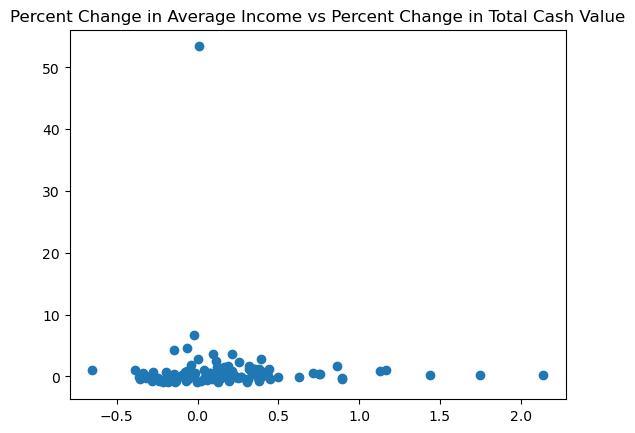

In [26]:
plt.scatter(ag_df['Change Value'], ag_df['Change Avg Gross'])
plt.title("Percent Change in Average Income vs Percent Change in Total Cash Value")
plt.show()

Outlier alert! What industry had a 500x growth in average gross in 5 years?

In [27]:
ag_df.loc[ag_df['Change Avg Gross'] == ag_df['Change Avg Gross'].max()]

,Year,State,Category,Value,Payments,Taxes,Cost Income Ratio,Liability,Labor,Avg Gross,Change Value,Change Avg Gross
184,2012,NORTH CAROLINA,Other Animals,158365000.0,3700000.0,1496.0,195.9,20928.0,1672.0,19522.0,0.007167,53.399139


Once again, what happened in the non-cattle, hog, or poultry livestock industries in North Carolina over those five years? Let's see what the 2017 value was:

In [28]:
survey_df.loc[(survey_df['Year'] == 2017) & (survey_df['State'] == 'NORTH CAROLINA') & (survey_df['Category'] == 'Other Animals')]

,Year,State,Category,Payments,Taxes,Cost Income Ratio,Liability,Labor,Avg Gross
289,2017,NORTH CAROLINA,Other Animals,2890000.0,2837.0,452.7,55366.0,8924.0,1061980.0


Ok, so apparently the average gross income per farm for some sort of livestock in North Carolina in 2017 was over a million dollars, up from 19 thousand in 2012. If we're right that average income can be used as an indicator of average farm size then this is a serious change in the makeup of the industry, especially as the total value changed by less than half a percent. Unfortunately, as much as this would be an interesting case study we're going to have to drop that row - it's just too much of an outlier given the amount of data we have access to. Let's do so an re-do that scatter plot.

In [29]:
ag_df = ag_df.drop(184)

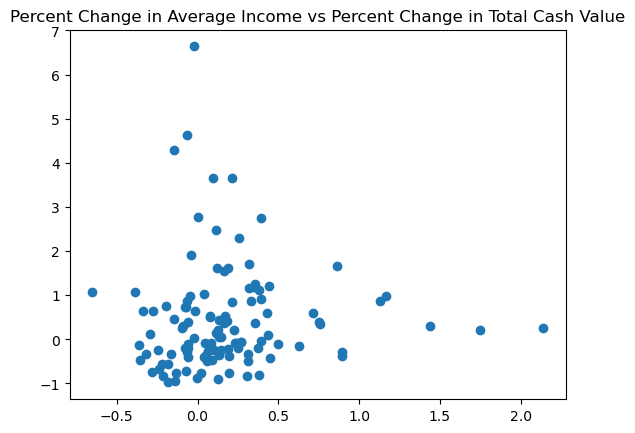

In [30]:
plt.scatter(ag_df['Change Value'], ag_df['Change Avg Gross'])
plt.title("Percent Change in Average Income vs Percent Change in Total Cash Value")
plt.show()

Much better. So - these are the two values we want to predict, but before we commit to a model we should check to see if it makes any sense whatsoever given our data. Let's check how the two values correlate with the dependent variables:

/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


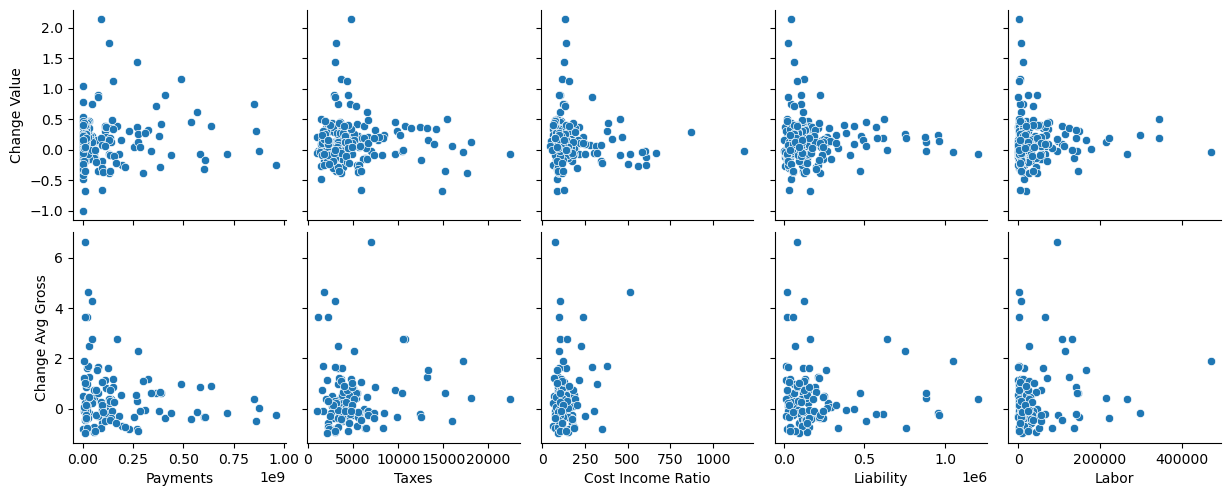

In [31]:
sns.pairplot(data=ag_df, y_vars=['Change Value', 'Change Avg Gross'], x_vars=['Payments', 'Taxes', 'Cost Income Ratio', 'Liability', 'Labor'])
plt.show()

Some of these look ok I guess (Payments for Change in Value for example) but there's definitely a few outliers - we're going to have to keep a close eye on the accuracy of our regression. Regardless, there's not much more we can say about the data here - let's get into some modeling prep.

## Regression Prep & Preliminary Regression

To reiterate from the intro, our goal here is to figure out what economic factors are relevant to both the overall direction of agricultural industries (in terms of raw production) and also the balance of small farm vs "Big Ag", for which we're using average gross income as a proxy (under the logic that large average income means large average farm size), so at the end of the day what I'm really interested in is the coefficients on our linear model, since those should tell us about the relative importance of the different factors found in our data. However, this doesn't mean we don't care about accuracy: we need our regression to perform well as a way to validate the coefficients. With that said, let's run a quick and dirty regression just to get an idea of whether this is even plausible. We'll start by standardizing all our data and dropping missing info:

In [32]:
ag_df = ag_df.dropna()
z_score_cols = ['Value', 'Payments', 'Taxes', 'Cost Income Ratio', 'Liability', 'Labor', 'Avg Gross']
ag_df[z_score_cols] = StandardScaler().fit_transform(ag_df[z_score_cols])
ag_df

,Year,State,Category,Value,Payments,Taxes,Cost Income Ratio,Liability,Labor,Avg Gross,Change Value,Change Avg Gross
0,2007,ARKANSAS,Cattle,-0.667663,-0.728904,-1.135288,1.582854,-0.776955,-0.621452,-0.880274,0.213337,3.660332
2,2007,ARKANSAS,Oilseed and Grain,-0.294223,1.085801,-0.660703,-0.396414,0.070942,0.019669,1.286655,0.893614,-0.369125
4,2007,ARKANSAS,Other Crops,-0.684775,-0.383583,-0.843204,0.599608,-0.479720,-0.210089,4.024571,-0.184644,-0.555503
5,2007,ARKANSAS,Poultry,0.046289,-0.825102,-0.711841,-0.965921,0.186522,-0.537780,-0.705003,0.078789,0.496535
7,2007,CALIFORNIA,Cattle,1.240780,-0.582526,3.447407,-0.491987,2.863848,2.427903,1.817367,0.132345,0.428677
...,...,...,...,...,...,...,...,...,...,...,...,...
201,2012,WASHINGTON,Specialty Crop,0.176878,-0.763632,0.545241,-0.856835,-0.213709,2.535510,2.255270,0.191871,-0.368466
202,2012,WISCONSIN,Cattle,0.721595,0.511237,-0.135115,-0.309195,0.145717,-0.289744,-0.365433,0.049298,-0.090697
204,2012,WISCONSIN,Oilseed and Grain,-0.145916,-0.061208,-0.208214,-0.293716,-0.248362,-0.568807,-0.431108,-0.218449,-0.566851
206,2012,WISCONSIN,Other Crops,-0.753290,-0.554999,-0.621199,0.070394,-0.707355,-0.615776,-0.698287,-0.004136,-0.881708


Wow, we lost a lot of data to that missing drop - we'll see how badly that hurts us in a second. Next we define our dependent and independent variables:

In [33]:
X = ag_df[['Payments', 'Taxes', 'Cost Income Ratio', 'Liability', 'Labor']]
Y_total = ag_df['Change Value']
Y_avg = ag_df['Change Avg Gross']

And now we can train and evaluate a linear model, which we'll do for each variable:

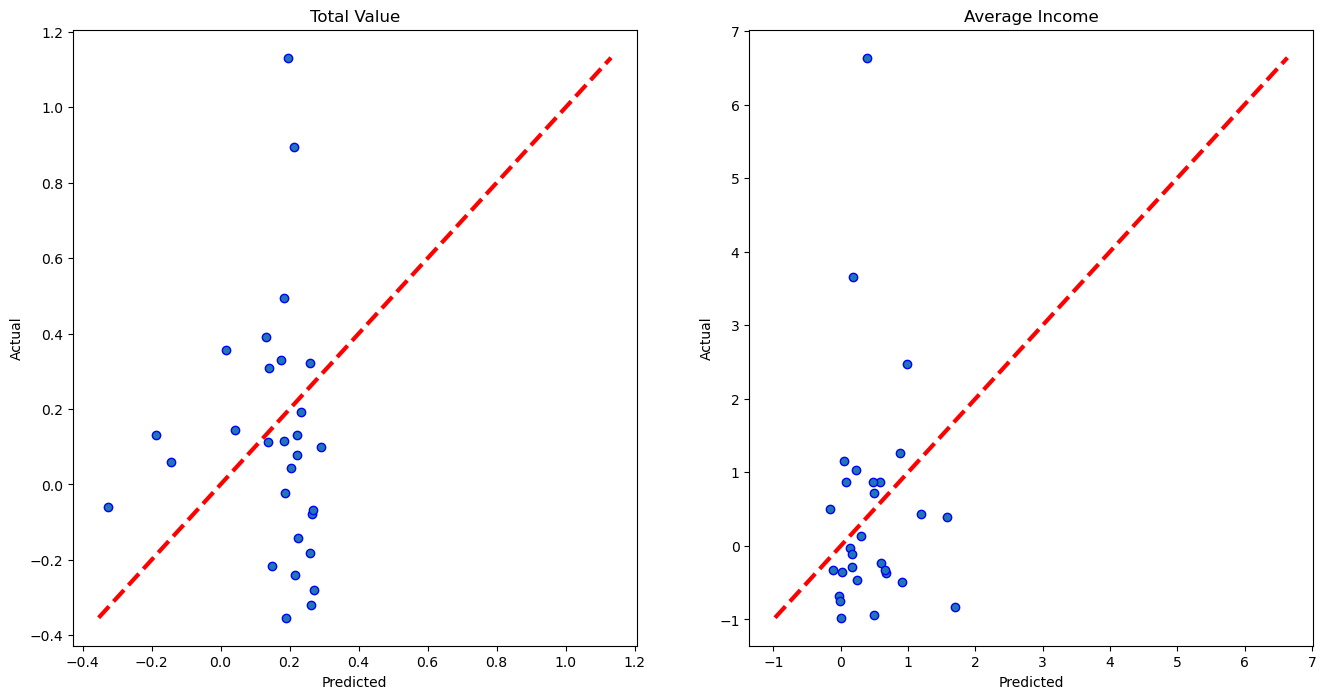

In [34]:
#First the change in total value of the industry:
X_train, X_test, y_train, y_test_total = train_test_split(X, Y_total, random_state=561)
total_value_model = LinearRegression()
total_value_model.fit(X_train, y_train)
total_predicted = total_value_model.predict(X_test)

#And the change in average income:
X_train, X_test, y_train, y_test_avg = train_test_split(X, Y_avg, random_state=561)
average_income_model = LinearRegression()
average_income_model.fit(X_train, y_train)
average_predicted = average_income_model.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].scatter(total_predicted, y_test_total, edgecolors=(0, 0, 1))
ax[0].plot([y_test_total.min(), y_test_total.max()], [y_test_total.min(), y_test_total.max()], 'r--', lw=3)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')
ax[0].set_title("Total Value")

ax[1].scatter(average_predicted, y_test_avg, edgecolors=(0, 0, 1))
ax[1].plot([y_test_avg.min(), y_test_avg.max()], [y_test_avg.min(), y_test_avg.max()], 'r--', lw=3)
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_title("Average Income")
plt.show()

We don't even need to look at the error stats to know this is not good. I'll close out here with some ways to move forward and fix our modeling approach for the final attempt:

* Option 1: Get more data/drop less. No doubt that a lot of our issues are cause by data scarcity issues - we went from 2300 instances to only 116 in the course of our cleaning and prep, which is a huge drop. If we can save more data or find more then we might get better models.
* Option 2: Change independent variables. None of the independent variables we dug up are that promising - and there are lots more available in the ARMS and USDA databases. There might be better options out there that we just aren't using yet.
* Option 3: New model. Linear might just not be the right option here, but this would be a bitter pill since our real goal is to extract the coefficients off the linear model to understand more about the relationship between individual economic measures and the agricultural industry. Option 1 and 2 are much more promising directions in this sense, and are the ways that I will be moving forward.